# NYCDSA Capstone Project: 
## <i>Predicting Insurance Fraud</i>
## Christopher Breuer
## August 24, 2021

In [1]:
import pandas as pd
import os
import seaborn as sns
from sklearn import svm
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
os.chdir(r"C:\Users\chris\OneDrive\OneDrive\DataAnalysis\Projects\capstone\hcFraud\data")
train = pd.read_csv("./Train.csv")
trainB = pd.read_csv("./Train_Beneficiary.csv")
trainIn = pd.read_csv("./Train_Inpatient.csv")
trainOut = pd.read_csv("./Train_Outpatient.csv")

  PotentialFraud  Number
0             No    4550
1            Yes     462


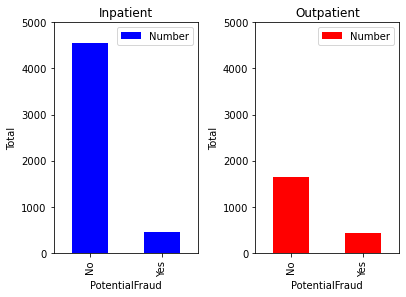

In [3]:
# EDA Fraction of In/Outpatient providers committing fraud

# Outpatient
allOut = pd.DataFrame(trainOut["Provider"].unique())
allOut.columns = ["Provider"]
allOut1 = pd.merge(allOut, train, how="left", on="Provider")
outNumbers = allOut1.groupby("PotentialFraud").count()
outNumbers.columns = ["Number"]
outNumbers.reset_index(inplace=True)

# Inpatient
allIn = pd.DataFrame(trainIn["Provider"].unique())
allIn.columns = ["Provider"]
allIn1 = pd.merge(allIn, train, how="left", on="Provider")
inNumbers = allIn1.groupby("PotentialFraud").count()
inNumbers.columns = ["Number"]
inNumbers.reset_index(inplace=True)
print(outNumbers)

## Visualizing fraud
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
fig.tight_layout()
outNumbers.plot(ax=axes[0], kind='bar', x="PotentialFraud", y='Number',color='b', ylabel="Total", title="Inpatient", ylim=(0,5000))
inNumbers.plot(ax=axes[1], kind='bar', x="PotentialFraud", y='Number',color='r', ylabel="Total", title="Outpatient",ylim=(0,5000))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [4]:
# Feature Engineering #1
# Repeat admissions inpatient

def countReadmissions(finalDF, InpatientDF, OutpatientDF, TestOrTrain):
    '''
    - Inputs are
            1) final data frame
            2) inpatient data frame
            3) outpatient data frame
    - Output is a data frame
           - first: provider:[patientsWithReadmission, total_readmissions]
           - then: converts to DF
           - then combines final with inpatient, and outpatient dfs
    '''
    x = OutpatientDF.groupby(["Provider", "BeneID"]).count()
    y = InpatientDF.groupby(["Provider", "BeneID"]).count()

    for DF in [x,y]:
        readmitDict = {}
        for prov, bene in DF.groupby(level = 0):
            if prov not in readmitDict.keys():

                # Number patients with >1 readmission, total readmissions, total patients
                readmitDict[prov] = [0,0,0]

            # For each beneficiary in this provider, if the number of rows for "ClaimID" >1 it's a readmission
            for i in bene["ClaimID"]:
                if i >1:
                    readmitDict[prov][0] += 1     # number of patients readmitted
                    readmitDict[prov][1] += i-1   # number of readmissions
                    readmitDict[prov][2] += 1     # total patients
                elif i == 1:
                    readmitDict[prov][2] += 1     # total patients
                else:
                    print("Error with value of number of readmissions.")
                    print("Value: ", i)
                    print("Qutting.")
                    exit()
        initial = pd.DataFrame.from_dict(readmitDict).T
        initial.columns = ["NumRe", "TotalRe", "Total"]
        initial["FractionRe"] = initial["NumRe"]/initial["Total"]
        initial.reset_index(inplace=True)
        initial = initial.rename(columns = {'index':'Provider'})
        finalDF = pd.merge(finalDF, initial, how="left", on="Provider")
        
        # Change column names. Test data lacks "Potential Fraud" column.
        if TestOrTrain == "Train":
            cnames = ['Provider', 'PotentialFraud','Out_NumRe','Out_TotalRe','Out_Total','Out_FractionRe','In_NumRe','In_TotalRe','In_Total','In_FractionRe']
        elif TestOrTrain == "Test":
            cnames = ['Provider', 'Out_NumRe','Out_TotalRe','Out_Total','Out_FractionRe','In_NumRe','In_TotalRe','In_Total','In_FractionRe']
    finalDF.columns = cnames
                
    return finalDF

In [5]:
# Add Readmission data to FDF:
# Number patients readmitted, Total Readmissions, Total Patients, Fraction of patients readmitted
# Note: there are 398 providers that have only inpatient OR outpatient services
#        there are 1694 providers that have BOTH
fdf = countReadmissions(train, trainIn, trainOut, "Train")

In [6]:
fdf

,Provider,PotentialFraud,Out_NumRe,Out_TotalRe,Out_Total,Out_FractionRe,In_NumRe,In_TotalRe,In_Total,In_FractionRe
0,PRV51001,No,1.0,1.0,19.0,0.052632,0.0,0.0,5.0,0.000000
1,PRV51003,Yes,4.0,4.0,66.0,0.060606,8.0,9.0,53.0,0.150943
2,PRV51004,No,8.0,11.0,138.0,0.057971,NaN,NaN,NaN,NaN
3,PRV51005,Yes,223.0,670.0,495.0,0.450505,NaN,NaN,NaN,NaN
4,PRV51007,No,10.0,13.0,56.0,0.178571,0.0,0.0,3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,4.0,4.0,24.0,0.166667,NaN,NaN,NaN,NaN
5406,PRV57760,No,4.0,13.0,9.0,0.444444,NaN,NaN,NaN,NaN
5407,PRV57761,No,11.0,15.0,67.0,0.164179,NaN,NaN,NaN,NaN
5408,PRV57762,No,0.0,0.0,1.0,0.000000,NaN,NaN,NaN,NaN


[Text(0, 0.5, 'Fraction Redmitted'),
 Text(0.5, 1.0, 'Fraction of Outpatients Readmitted')]

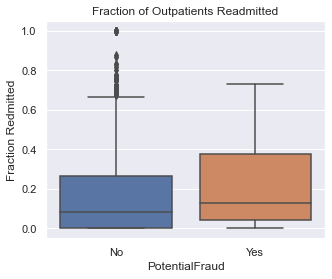

In [7]:
# Outpatient readmissions

sns.set(rc={"figure.figsize":(5,4)})
g = sns.boxplot(data=fdf, x="PotentialFraud", y="Out_FractionRe")
g.set(ylabel="Fraction Redmitted", title="Fraction of Outpatients Readmitted")

[Text(0, 0.5, 'Number of Redmitted Patients'),
 Text(0.5, 0, 'Total Patients Per Provider'),
 Text(0.5, 1.0, 'Inpatient Readmissions')]

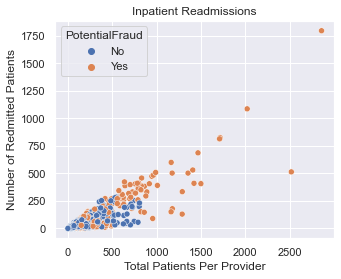

In [8]:
# Outpatient readmissions

sns.set(rc={"figure.figsize":(5,4)})
g = sns.scatterplot(data=fdf, y="Out_NumRe", x="Out_Total", hue="PotentialFraud")
g.set(ylabel="Number of Redmitted Patients", xlabel="Total Patients Per Provider", title="Inpatient Readmissions")

[Text(0, 0.5, 'Number of Redmitted Patients'),
 Text(0.5, 0, 'Total Patients Per Provider'),
 Text(0.5, 1.0, 'Inpatient Readmissions')]

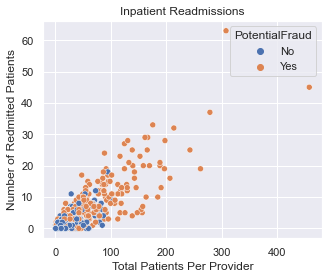

In [9]:
# Inpatient readmissions

sns.set(rc={"figure.figsize":(5,4)})
g = sns.scatterplot(data=fdf, y="In_NumRe", x="In_Total", hue="PotentialFraud")
g.set(ylabel="Number of Redmitted Patients", xlabel="Total Patients Per Provider", title="Inpatient Readmissions")

In [10]:
# Field engineering #2
# Cost per patient --> merge with final data frame
# Note: SD is normalized to the mean for the purposes of comparison

def costPerPatient(finalDF, inpatientData, outpatientData):
    '''
    - input is 3 data frames:
            1) final DF
            2) inpatient DF
            3) outpatient DF
    - output is final data frame merged with inpatient and outpatient cost per patient (avg and sdm)
    '''
    aggregate = ["sum", "count", "mean", "std"]
    
    # Inpatient data
    x = inpatientData.groupby(["Provider"])["InscClaimAmtReimbursed"].agg(aggregate)
    x.reset_index(inplace=True)
    x.columns = ["Provider"] + ["In_TotalCharge", "In_TotalPatients", "In_MeanCostPP", "In_NormCostSDpp"]
    x["In_NormCostSDpp"] = x["In_NormCostSDpp"]/x["In_MeanCostPP"]
    
    # Outpatient data
    y = outpatientData.groupby(["Provider"])["InscClaimAmtReimbursed"].agg(aggregate)
    y.reset_index(inplace=True)
    y.columns = ["Provider"] + ["Out_TotalCharge", "Out_TotalPatients", "Out_MeanCostPP", "Out_NormCostSDpp"]
    y["In_NormCostSDpp"] = y["Out_NormCostSDpp"]/y["Out_MeanCostPP"]

    finalDF = pd.merge(finalDF, x, how="left", on="Provider")
    finalDF = pd.merge(finalDF, y, how="left", on="Provider")
    
    return finalDF

In [11]:
# Add cost per patient to the FDF
fdf2 = costPerPatient(fdf, trainIn, trainOut)

In [12]:
fdf2

,Provider,PotentialFraud,Out_NumRe,Out_TotalRe,Out_Total,Out_FractionRe,In_NumRe,In_TotalRe,In_Total,In_FractionRe,In_TotalCharge,In_TotalPatients,In_MeanCostPP,In_NormCostSDpp_x,Out_TotalCharge,Out_TotalPatients,Out_MeanCostPP,Out_NormCostSDpp,In_NormCostSDpp_y
0,PRV51001,No,1.0,1.0,19.0,0.052632,0.0,0.0,5.0,0.000000,97000.0,5.0,19400.000000,0.945985,7640.0,20.0,382.000000,422.817617,1.106852
1,PRV51003,Yes,4.0,4.0,66.0,0.060606,8.0,9.0,53.0,0.150943,573000.0,62.0,9241.935484,0.921193,32670.0,70.0,466.714286,821.364579,1.759887
2,PRV51004,No,8.0,11.0,138.0,0.057971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52170.0,149.0,350.134228,689.963754,1.970569
3,PRV51005,Yes,223.0,670.0,495.0,0.450505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280910.0,1165.0,241.124464,491.556392,2.038600
4,PRV51007,No,10.0,13.0,56.0,0.178571,0.0,0.0,3.0,0.000000,19000.0,3.0,6333.333333,0.554508,14710.0,69.0,213.188406,447.231657,2.097824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,4.0,4.0,24.0,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10640.0,28.0,380.000000,820.880286,2.160211
5406,PRV57760,No,4.0,13.0,9.0,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4770.0,22.0,216.818182,309.998254,1.429761
5407,PRV57761,No,11.0,15.0,67.0,0.164179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18470.0,82.0,225.243902,418.366092,1.857391
5408,PRV57762,No,0.0,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900.0,1.0,1900.000000,NaN,NaN


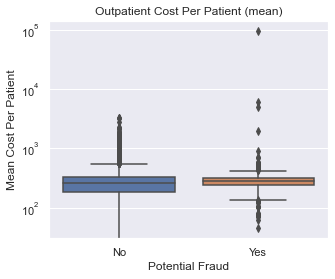

In [13]:
# Outpatient cost per person
# Note 3 outliers in fraud category

sns.set(rc={"figure.figsize":(5,4)})
g = sns.boxplot(data=fdf2, y="Out_MeanCostPP", x="PotentialFraud")
g.set(ylabel="Mean Cost Per Patient", xlabel="Potential Fraud", title="Outpatient Cost Per Patient (mean)")
g.set_yscale("log")

(0.0, 2000.0)

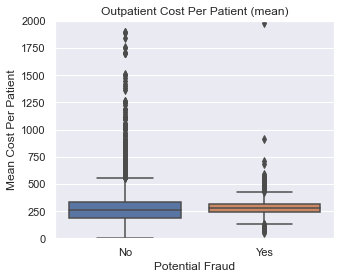

In [14]:
# Outpatient cost per person
# Redisplayed data (same as above, different scale)

sns.set(rc={"figure.figsize":(5,4)})
g = sns.boxplot(data=fdf2, y="Out_MeanCostPP", x="PotentialFraud")
g.set(ylabel="Mean Cost Per Patient", xlabel="Potential Fraud", title="Outpatient Cost Per Patient (mean)")
g.set_ylim(0,2000)

[Text(0, 0.5, 'Mean Cost Per Patient'),
 Text(0.5, 0, 'Potential Fraud'),
 Text(0.5, 1.0, 'Inpatient Cost Per Patient (mean)')]

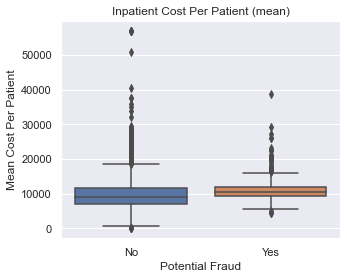

In [15]:
# Inpatient cost per person
# Not necessarily informative: higher mean, but no outliers

sns.set(rc={"figure.figsize":(5,4)})
g = sns.boxplot(data=fdf2, y="In_MeanCostPP", x="PotentialFraud")
g.set(ylabel="Mean Cost Per Patient", xlabel="Potential Fraud", title="Inpatient Cost Per Patient (mean)")

[Text(0, 0.5, 'Norm. STDEV of Cost/Patient'),
 Text(0.5, 0, 'Potential Fraud'),
 Text(0.5, 1.0, 'SD of Cost Per Patient (Inpatient)')]

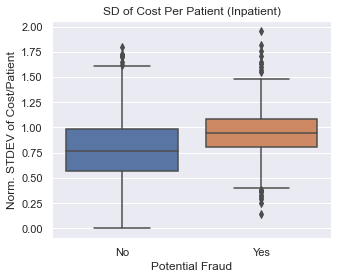

In [16]:
# SD cost per person: Inpatient

sns.set(rc={"figure.figsize":(5,4)})
g = sns.boxplot(data=fdf2, y="In_NormCostSDpp_x", x="PotentialFraud")
g.set(ylabel="Norm. STDEV of Cost/Patient", xlabel="Potential Fraud", title="SD of Cost Per Patient (Inpatient)")
#g.set_yscale("log")
#g.set_ylim(0,40000)

[Text(0, 0.5, 'Norm. STDEV of Cost/Patient'),
 Text(0.5, 0, 'Potential Fraud'),
 Text(0.5, 1.0, 'Inpatient Cost Per Patient (SD)')]

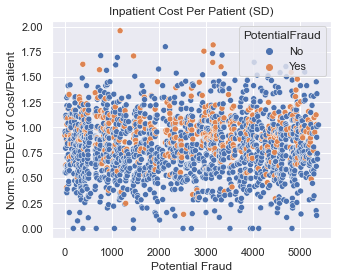

In [17]:
# SD cost per person: Inpatient

g = sns.scatterplot(data=fdf2, y="In_NormCostSDpp_x", x= fdf2.index, hue="PotentialFraud")
g.set(ylabel="Norm. STDEV of Cost/Patient", xlabel="Potential Fraud", title="Inpatient Cost Per Patient (SD)")
#g.set_yscale("log")
#g.set_ylim(0,40000)

In [18]:
# Data engineering #4 (1 of X)
# Billing $/month

def billingPerMonth(finalDF, inpatientData, outpatientData):
    '''
    - input is 3 data frames:
            1) final DF
            2) inpatient DF
            3) outpatient DF
    - output is a DF:
            - all monthly charges (row) by provider (column)
            - purpose: graph everything out, look for outliers
    '''
    aggregate = ["sum"]
    
    # remove DAY from DATE > only YEAR-MONTH
    inpatientData["FixDt"] = inpatientData["ClaimEndDt"].str[:7]
    outpatientData["FixDt"] = outpatientData["ClaimEndDt"].str[:7]
    
    # Calculate Provider:Month:TotalCost
    inData = inpatientData.groupby(["Provider", "FixDt"])["InscClaimAmtReimbursed"].agg(aggregate)
    outData = outpatientData.groupby(["Provider", "FixDt"])["InscClaimAmtReimbursed"].agg(aggregate)
    
    # Inpatient data
    in_monthlyCosts = {}
    for prov, bene in inData.groupby(level = 0):
        in_monthlyCosts[prov] = []
        # For each beneficiary in this provider, if the number of rows for "ClaimID" >1 it's a readmission
        for i in bene["sum"]:
            in_monthlyCosts[prov].append(i)
    
    out_monthlyCosts = {}
    for prov, bene in outData.groupby(level = 0):
        out_monthlyCosts[prov] = []
        # For each beneficiary in this provider, if the number of rows for "ClaimID" >1 it's a readmission
        for i in bene["sum"]:
            out_monthlyCosts[prov].append(i)
    
    # Make a data frame - all columns must be the same length
    # To make same length, finding longest data set, and filling in all others with according number of zeros
    DFs = [in_monthlyCosts, out_monthlyCosts]
    for DF in DFs:
        longest = 0
        keys = DF.keys()
        for key in keys:
            dataLength = len(DF[key])
            if longest < dataLength:
                longest = dataLength

        # Fill in zero values
        for key in keys:
            data = DF[key]
            datapoints = len(data)
            if datapoints < longest:
                diff = longest - datapoints
                for x in range(diff):
                    data.append(0)
    inMonthly = pd.DataFrame.from_dict(in_monthlyCosts)
    inMonthly["idx"] = inMonthly.index
    outMonthly = pd.DataFrame.from_dict(out_monthlyCosts)
    outMonthly["idx"] = outMonthly.index
    
    # Melt the data into a 2-column data set
    cols = list(inMonthly.columns)
    del cols[-1]
    inMonthly = pd.melt(inMonthly, id_vars=['idx'], value_vars=cols)
    inMonthly.drop(["idx"], axis=1, inplace=True)
    inMonthly.columns = ["Provider", "inMonthlyCharge"]

    cols = list(outMonthly.columns)
    del cols[-1]
    outMonthly = pd.melt(outMonthly, id_vars=['idx'], value_vars=cols)
    outMonthly.drop(["idx"], axis=1, inplace=True)
    outMonthly.columns = ["Provider", "outMonthlyCharge"]
    
    # Add fraud data
    outMonthly2 = pd.merge(outMonthly, finalDF, how="left", on="Provider")
    inMonthly2 = pd.merge(inMonthly, finalDF, how="left", on="Provider")
    
    
    return inMonthly2, outMonthly2


In [19]:
# Monthly bills
inMC, outMC = billingPerMonth(train, trainIn, trainOut)

In [20]:
inMC

,Provider,inMonthlyCharge,PotentialFraud
0,PRV51001,7000,No
1,PRV51001,54000,No
2,PRV51001,36000,No
3,PRV51001,0,No
4,PRV51001,0,No
...,...,...,...
25099,PRV57757,4000,No
25100,PRV57757,0,No
25101,PRV57757,0,No
25102,PRV57757,0,No


[Text(0, 0.5, 'Charges/Month'),
 Text(0.5, 0, 'Provider'),
 Text(0.5, 1.0, 'Inpatient Charges Per Month by Provider')]

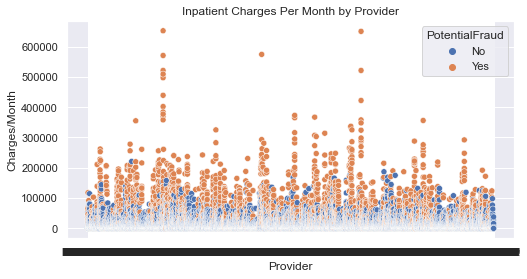

In [21]:
# Monthly bills by provider

sns.set(rc={"figure.figsize":(8, 4)})
g = sns.scatterplot(data=inMC, x="Provider", y="inMonthlyCharge", hue="PotentialFraud")
g.set(ylabel="Charges/Month", xlabel="Provider", title="Inpatient Charges Per Month by Provider")
#g.set_yscale("log")
#g.set_ylim(0,40000)

[Text(0, 0.5, 'Charges/Month'),
 Text(0.5, 0, 'Potential Fraud'),
 Text(0.5, 1.0, 'Outpatient Charges Per Month')]

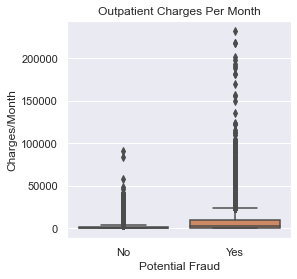

In [22]:
# Monthly bills by provider
# Conclusions: clear relationship between higher mothly charge and fraud
# Problem: Distribution of monthly charges means this column needs to be aggregated to a single value so it 
#          can be matched with the training data of 1 row per Provide:Fraud.

sns.set(rc={"figure.figsize":(4, 4)})
g = sns.boxplot(data=outMC, x="PotentialFraud", y="outMonthlyCharge")
g.set(ylabel="Charges/Month", xlabel="Potential Fraud", title="Outpatient Charges Per Month")

In [23]:
# Data Engineering:     Top monthly charge per provider

aggregate = ["max"]
TopChargesIn = inMC.groupby(["Provider"])["inMonthlyCharge"].agg(aggregate)
TopChargesIn.reset_index(inplace=True)
TopChargesIn = pd.merge(TopChargesIn, inMC.drop(["inMonthlyCharge"], axis=1), how="left", on="Provider")
TopChargesIn.drop_duplicates(inplace=True)
TopChargesIn.columns = ["Provider", "InMaxChargePerMo", "PotentialFraud"]

TopChargesOut = outMC.groupby(["Provider"])["outMonthlyCharge"].agg(aggregate)
TopChargesOut.reset_index(inplace=True)
TopChargesOut = pd.merge(TopChargesOut, outMC.drop(["outMonthlyCharge"], axis=1), how="left", on="Provider")
TopChargesOut.drop_duplicates(inplace=True)
TopChargesOut.columns = ["Provider", "OutMaxChargePerMo", "PotentialFraud"]

In [24]:
TopChargesIn

,Provider,InMaxChargePerMo,PotentialFraud
0,PRV51001,54000,No
12,PRV51003,118000,Yes
24,PRV51007,10000,No
36,PRV51008,21000,No
48,PRV51011,5000,No
...,...,...,...
25044,PRV57719,64000,No
25056,PRV57728,6000,No
25068,PRV57729,28000,No
25080,PRV57732,27000,No


[Text(0, 0.5, 'Max Charge/Month'),
 Text(0.5, 0, 'Provider'),
 Text(0.5, 1.0, 'Outpatient Max Charge Per Month')]

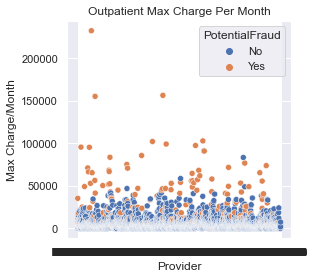

In [25]:
# EDA: Highest **Outpatient** Monthly bill per provider

sns.set(rc={"figure.figsize":(4, 4)})
g = sns.scatterplot(data=TopChargesOut, x="Provider", y="OutMaxChargePerMo", hue="PotentialFraud")
g.set(ylabel="Max Charge/Month", xlabel="Provider", title="Outpatient Max Charge Per Month")

In [26]:
# Keep data: add top monthly charge to final data frame

# Add outpatient data
fdf3 = pd.merge(fdf2, TopChargesOut.drop(["PotentialFraud"], axis=1), how="left", on="Provider")
# Add inpatient data
fdf3 = pd.merge(fdf3, TopChargesIn.drop(["PotentialFraud"], axis=1), how="left", on="Provider")

In [27]:
fdf3

,Provider,PotentialFraud,Out_NumRe,Out_TotalRe,Out_Total,Out_FractionRe,In_NumRe,In_TotalRe,In_Total,In_FractionRe,...,In_TotalPatients,In_MeanCostPP,In_NormCostSDpp_x,Out_TotalCharge,Out_TotalPatients,Out_MeanCostPP,Out_NormCostSDpp,In_NormCostSDpp_y,OutMaxChargePerMo,InMaxChargePerMo
0,PRV51001,No,1.0,1.0,19.0,0.052632,0.0,0.0,5.0,0.000000,...,5.0,19400.000000,0.945985,7640.0,20.0,382.000000,422.817617,1.106852,1600.0,54000.0
1,PRV51003,Yes,4.0,4.0,66.0,0.060606,8.0,9.0,53.0,0.150943,...,62.0,9241.935484,0.921193,32670.0,70.0,466.714286,821.364579,1.759887,6160.0,118000.0
2,PRV51004,No,8.0,11.0,138.0,0.057971,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,52170.0,149.0,350.134228,689.963754,1.970569,7340.0,NaN
3,PRV51005,Yes,223.0,670.0,495.0,0.450505,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,280910.0,1165.0,241.124464,491.556392,2.038600,35370.0,NaN
4,PRV51007,No,10.0,13.0,56.0,0.178571,0.0,0.0,3.0,0.000000,...,3.0,6333.333333,0.554508,14710.0,69.0,213.188406,447.231657,2.097824,3610.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,4.0,4.0,24.0,0.166667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10640.0,28.0,380.000000,820.880286,2.160211,3350.0,NaN
5406,PRV57760,No,4.0,13.0,9.0,0.444444,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4770.0,22.0,216.818182,309.998254,1.429761,1630.0,NaN
5407,PRV57761,No,11.0,15.0,67.0,0.164179,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18470.0,82.0,225.243902,418.366092,1.857391,4800.0,NaN
5408,PRV57762,No,0.0,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1900.0,1.0,1900.000000,NaN,NaN,1900.0,NaN


In [28]:
def noPhysician(dataDF, providerDF, InOut):
    '''
    - Count the number of claims with no attending physician in the input dataframe
    - input:
        - dataDF = medical data (either test/train inpatient/outpatient data)
        - providerDF = aggregated data for downstream analysis
        - InOut = indicates if it's inpatient or outpatient data (used for column labelling)
    - output is providerDF with additional column of Provider:Number of zero physician claims
    '''
    # Replace NaN with 0
    t2 = dataDF.fillna(value=0, axis=1)
    
    # Count number of physicians per insurance charge
    t2["AttendingPhysicianNum"] = t2["AttendingPhysician"].apply(lambda x: 1 if x != 0 else 0)
    t2["OperatingPhysicianNum"] = t2["OperatingPhysician"].apply(lambda x: 1 if x != 0 else 0)
    t2["OtherPhysicianNum"] = t2["OtherPhysician"].apply(lambda x: 1 if x != 0 else 0)
    t2["NumPhys"] = t2["AttendingPhysicianNum"] + t2["OperatingPhysicianNum"] + t2["OtherPhysicianNum"]
    
    # If there's at least 1 physician on record the record is normal and therefore not counted: classified as 0
    # If there are zero physicians listed, the number is counted, so it's a 1
    t2["PhysYN"] = t2["NumPhys"].apply(lambda x: 0 if x >=1 else 1)
    physData = t2.groupby(["Provider"])["PhysYN"].agg(["sum"])
    physData.reset_index(inplace=True)
    physData.columns = ["Provider", InOut + "_NoPhys"]
    pdOut = pd.merge(providerDF, physData, how="left", on="Provider")
    
    return pdOut

In [29]:
# Count the number of no-physician claims Inpatient
fdf4 = noPhysician(trainIn, fdf3, "In")
# Count number of no-physician claims Outpatient
fdf5 = noPhysician(trainOut, fdf4, "Out")
fdf5

,Provider,PotentialFraud,Out_NumRe,Out_TotalRe,Out_Total,Out_FractionRe,In_NumRe,In_TotalRe,In_Total,In_FractionRe,...,In_NormCostSDpp_x,Out_TotalCharge,Out_TotalPatients,Out_MeanCostPP,Out_NormCostSDpp,In_NormCostSDpp_y,OutMaxChargePerMo,InMaxChargePerMo,In_NoPhys,Out_NoPhys
0,PRV51001,No,1.0,1.0,19.0,0.052632,0.0,0.0,5.0,0.000000,...,0.945985,7640.0,20.0,382.000000,422.817617,1.106852,1600.0,54000.0,0.0,0.0
1,PRV51003,Yes,4.0,4.0,66.0,0.060606,8.0,9.0,53.0,0.150943,...,0.921193,32670.0,70.0,466.714286,821.364579,1.759887,6160.0,118000.0,0.0,0.0
2,PRV51004,No,8.0,11.0,138.0,0.057971,NaN,NaN,NaN,NaN,...,NaN,52170.0,149.0,350.134228,689.963754,1.970569,7340.0,NaN,NaN,0.0
3,PRV51005,Yes,223.0,670.0,495.0,0.450505,NaN,NaN,NaN,NaN,...,NaN,280910.0,1165.0,241.124464,491.556392,2.038600,35370.0,NaN,NaN,2.0
4,PRV51007,No,10.0,13.0,56.0,0.178571,0.0,0.0,3.0,0.000000,...,0.554508,14710.0,69.0,213.188406,447.231657,2.097824,3610.0,10000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,4.0,4.0,24.0,0.166667,NaN,NaN,NaN,NaN,...,NaN,10640.0,28.0,380.000000,820.880286,2.160211,3350.0,NaN,NaN,0.0
5406,PRV57760,No,4.0,13.0,9.0,0.444444,NaN,NaN,NaN,NaN,...,NaN,4770.0,22.0,216.818182,309.998254,1.429761,1630.0,NaN,NaN,0.0
5407,PRV57761,No,11.0,15.0,67.0,0.164179,NaN,NaN,NaN,NaN,...,NaN,18470.0,82.0,225.243902,418.366092,1.857391,4800.0,NaN,NaN,0.0
5408,PRV57762,No,0.0,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,1900.0,1.0,1900.000000,NaN,NaN,1900.0,NaN,NaN,0.0


In [30]:
trainIn

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,FixDt
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-04
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,2009-09
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,2009-02
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,2009-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000,PHY345332,PHY319565,NaN,2009-09-28,...,70704,2869,4148,9904.0,NaN,NaN,NaN,NaN,NaN,2009-10
40470,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000,PHY342806,PHY365497,NaN,2009-11-03,...,4254,5990,NaN,8605.0,NaN,NaN,NaN,NaN,NaN,2009-11
40471,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000,PHY423220,PHY332752,NaN,2009-11-18,...,71590,V4502,NaN,9390.0,NaN,NaN,NaN,NaN,NaN,2009-11
40472,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000,PHY353156,NaN,NaN,2009-12-17,...,0414,41400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-12


In [31]:
def durationOfAdmission(finalDF, inData):
    '''
    - input is 2 data frames:
            1) final DF
            2) inpatient DF
    - output is finalDF plus column:
            - length of hospital stay
    '''
    inData["InDurationDays"] = pd.to_datetime(inData["ClaimEndDt"]) - pd.to_datetime(inData["ClaimStartDt"])
    inData['InDurationDays'] = inData['InDurationDays'].apply(lambda x: str(x).split(" ")[0])
    inData['InDurationDays'] = inData['InDurationDays'].astype(int)
    analysis = inData.groupby(["Provider"])["InDurationDays"].agg(["max", "mean"])
    analysis.columns = ["MaxInDays", "MeanInDays"]
    analysis.reset_index(inplace=True)
    pdOut = pd.merge(finalDF, analysis, how="left", on="Provider")

    return pdOut

In [32]:
# Add duration of inpatient hospital admission to final data frame
fdf6 = durationOfAdmission(fdf5, trainIn)

In [33]:
def raceAndChronic(finalDF, beneDF, InpatientDF, OutpatientDF):
    '''
    - Analyzes (average) of whether patients do/do not have each chronic condition
    - Added in Race because it the same type of information
    '''
    bData = beneDF[["BeneID", "ChronicCond_Depression", "ChronicCond_Diabetes","ChronicCond_IschemicHeart",
             "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "Race"]].copy()
    conditions = ["ChronicCond_Depression", "ChronicCond_Diabetes","ChronicCond_IschemicHeart",
             "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "Race"]
    
    inMerge = pd.merge(InpatientDF, bData, on="BeneID")
    outMerge = pd.merge(OutpatientDF, bData, on="BeneID")
    
    # Outpatient
    for cc in conditions:
        analysis = outMerge.groupby(["Provider"])[cc].agg(["mean"])  # average == more/less each chronic condition
        analysis.columns = ["OutAv_" + cc]
        finalDF = pd.merge(finalDF, analysis, how="left", on="Provider")
    
    # Same for inpatient
    for cc in conditions:
        analysis = inMerge.groupby(["Provider"])[cc].agg(["mean"])  # average == more/less each chronic condition
        analysis.columns = ["InAv_" + cc]
        finalDF = pd.merge(finalDF, analysis, how="left", on="Provider")
    
    return finalDF

In [34]:
# Add in average patient profiles by provider: 1) Race and 2) Each chronic disease
# Get info from inpatient and outpatient data
fdf7 = raceAndChronic(fdf6, trainB, trainIn, trainOut)
fdf7

,Provider,PotentialFraud,Out_NumRe,Out_TotalRe,Out_Total,Out_FractionRe,In_NumRe,In_TotalRe,In_Total,In_FractionRe,...,OutAv_ChronicCond_rheumatoidarthritis,OutAv_ChronicCond_stroke,OutAv_Race,InAv_ChronicCond_Depression,InAv_ChronicCond_Diabetes,InAv_ChronicCond_IschemicHeart,InAv_ChronicCond_Osteoporasis,InAv_ChronicCond_rheumatoidarthritis,InAv_ChronicCond_stroke,InAv_Race
0,PRV51001,No,1.0,1.0,19.0,0.052632,0.0,0.0,5.0,0.000000,...,1.750000,1.800000,1.200000,1.200000,1.200000,1.200000,2.000000,1.400000,1.600000,1.000000
1,PRV51003,Yes,4.0,4.0,66.0,0.060606,8.0,9.0,53.0,0.150943,...,1.728571,1.928571,1.214286,1.596774,1.209677,1.112903,1.790323,1.693548,1.887097,1.209677
2,PRV51004,No,8.0,11.0,138.0,0.057971,NaN,NaN,NaN,NaN,...,1.691275,1.885906,1.228188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PRV51005,Yes,223.0,670.0,495.0,0.450505,NaN,NaN,NaN,NaN,...,1.715880,1.893562,1.242060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PRV51007,No,10.0,13.0,56.0,0.178571,0.0,0.0,3.0,0.000000,...,1.695652,1.855072,1.202899,1.333333,1.000000,1.000000,2.000000,1.666667,1.333333,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,4.0,4.0,24.0,0.166667,NaN,NaN,NaN,NaN,...,1.678571,1.857143,1.642857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5406,PRV57760,No,4.0,13.0,9.0,0.444444,NaN,NaN,NaN,NaN,...,1.954545,2.000000,1.181818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5407,PRV57761,No,11.0,15.0,67.0,0.164179,NaN,NaN,NaN,NaN,...,1.707317,1.878049,1.304878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5408,PRV57762,No,0.0,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,...,2.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
##############################################################################################################
# Data cleaning Start
##############################################################################################################
def cleanData(finalData):
    '''
    - input is final data frame
    - output is cleaned final data frame
        - replace NaN with 0
        - replace Yes/No with 1 or 0
        - All data is numeric type
    '''
    # Replace NaN with 0
    cd1 = finalData.fillna(value=0, axis=1)
    
    # Change Yes/No to 1/0
    cd1.PotentialFraud = np.where((cd1.PotentialFraud == "No"),0, np.where((cd1.PotentialFraud == "Yes"),1, cd1.PotentialFraud))
    
    # Convert 1/0 Potential fraud to type=int (3 of 4)
    cd1.PotentialFraud = cd1.PotentialFraud.astype(int)

    return cd1

In [36]:
# Clean up the data: replaces NaNs and convert Yes/No results to numeric
fdf8 = cleanData(fdf7)

In [37]:
# Create training/test data

from sklearn.model_selection import train_test_split
Xdata = fdf8.drop(["Provider", "PotentialFraud"], axis=1)
Ydata = fdf8["PotentialFraud"]                 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.3)

In [38]:
##############################################################################################################
# XG Boosting Train:
##############################################################################################################
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()

In [39]:
# Train boosting model 
InitialModel = gbm.fit(Xtrain, Ytrain)

In [40]:
# Full data set yields:
# Rsquared for training data: 0.979
# Rsquared for test data: 0.936

# Feature removal testing 1
# Removing ["OutAv_Race", "In_NoPhys", "InAv_ChronicCond_rheumatoidarthritis", "Out_NumRe", "Out_NoPhys","Out_FractionRe"]
# Rsquared for training data: 0.975
# Rsquared for test data: 0.954

# Feature removal testing 2
# above features plus ... "InAv_ChronicCond_Depression", "OutAv_ChronicCond_Osteoporasis"]
# Rsquared for training data: 0.978
# Rsquared for test data: 0.937

# Feature removal testing 3
# above features plus ... "Out_MeanCostPP"]
# Rsquared for training data: 0.979
# Rsquared for test data: 0.939


InitialTestR2 = Initial.score(Xtest, Ytest)
InitialTrainR2 = InitialModel.score(Xtrain, Ytrain)

print('Rsquared for training data: %.3f' %(InitialTrainR2))
print('Rsquared for test data: %.3f' %(InitialTestR2))

NameError: name 'Initial' is not defined

In [41]:
# Feature Importances 
FI = pd.DataFrame({'Feature':Xtrain.columns, 'Importance':list(InitialModel.feature_importances_)})
FI = FI.sort_values(by="Importance", ascending=False)

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

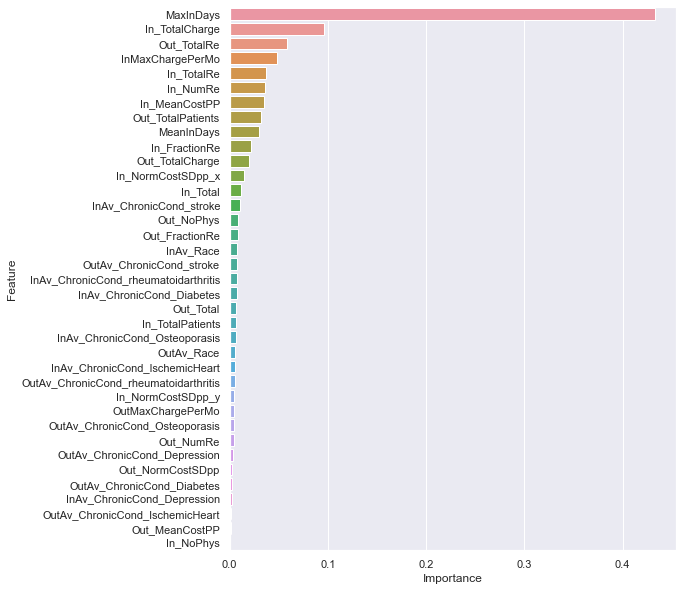

In [42]:
# Plot out feature importance
sns.set(rc={"figure.figsize":(8, 10)})
sns.barplot(data=FI,y="Feature",x="Importance")

In [43]:
# Confusion matrix (test data)
from sklearn.metrics import confusion_matrix
pred = pd.DataFrame({"Prediction":InitialModel.predict(Xtest)})
ydata = pd.DataFrame({"Actual":Ytest})
ydata.index = pred.index
pred["Actual"] = ydata["Actual"]
cm = pd.DataFrame(confusion_matrix(pred["Actual"], pred["Prediction"]))
cm.index = ["No Fraud", "Fraud"]
cm.columns = ["No Fraud", "Fraud"]
cm

,No Fraud,Fraud
No Fraud,1442,41
Fraud,57,83


Text(21.499999999999996, 0.5, 'Actual')

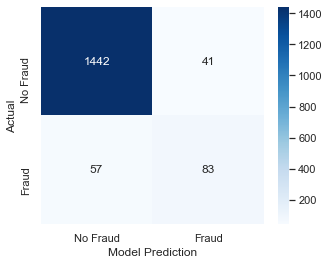

In [44]:
# Plot the confusion matrix
#fig = plt.figure()
sns.set(rc={"figure.figsize":(5,4)})
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
ax.set_xlabel ('Model Prediction', fontsize = 12)
ax.set_ylabel ('Actual', fontsize = 12)

In [45]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(Xdata, Ydata)

In [46]:
# Train boosting model on SMOTE data
newModel = gbm.fit(x_res, y_res)

In [47]:
# SMOTE model scores
modelScoreTrain = newModel.score(Xtrain, Ytrain)
modelScoreTest = newModel.score(Xtest, Ytest)
modelScoreAll = newModel.score(Xdata, Ydata)
print('Rsquared for training data: %.3f' %(modelScoreTrain))
print('Rsquared for test data: %.3f' %(modelScoreTest))
print('Rsquared for all data: %.3f' %(modelScoreAll))

Rsquared for training data: 0.945
Rsquared for test data: 0.942
Rsquared for all data: 0.944


In [48]:
# Feature Importances 
FI = pd.DataFrame({'Feature':Xtrain.columns, 'Importance':list(newModel.feature_importances_)})
FI = FI.sort_values(by="Importance", ascending=False)

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

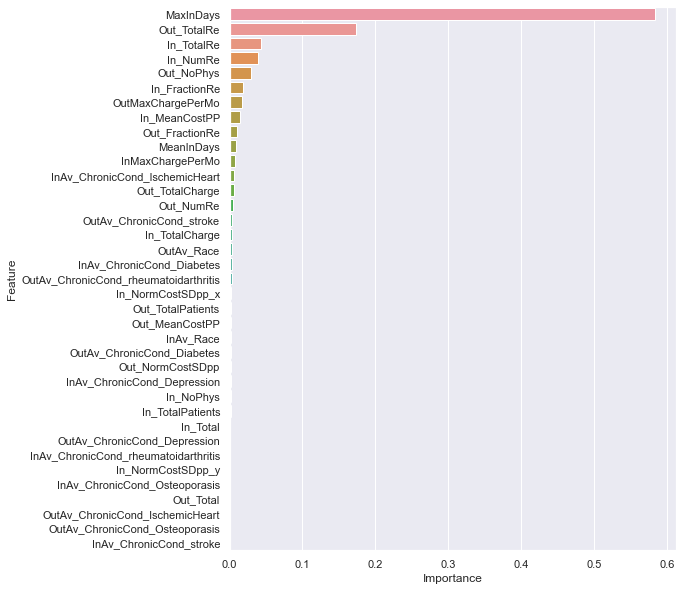

In [49]:
# Plot out feature importance
sns.set(rc={"figure.figsize":(8, 10)})
sns.barplot(data=FI,y="Feature",x="Importance")

In [50]:
# Confusion matrix for SMOTE model on whole data set
from sklearn.metrics import confusion_matrix
pred = pd.DataFrame({"Prediction":newModel.predict(Xdata)})
ydata = pd.DataFrame({"Actual":Ydata})
ydata.index = pred.index
pred["Actual"] = ydata["Actual"]
confMat = pd.DataFrame(confusion_matrix(pred["Actual"], pred["Prediction"]))
confMat.index = ["No Fraud", "Fraud"]
confMat.columns = ["No Fraud", "Fraud"]
confMat

,No Fraud,Fraud
No Fraud,4660,244
Fraud,58,448


Text(21.499999999999996, 0.5, 'Actual')

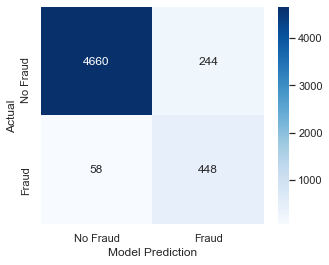

In [51]:
# Plot the confusion matrix (SMOTE Model on Full Data Set)
#fig = plt.figure()
sns.set(rc={"figure.figsize":(5,4)})
ax = sns.heatmap(confMat, annot=True, fmt='g', cmap="Blues")
ax.set_xlabel ('Model Prediction', fontsize = 12)
ax.set_ylabel ('Actual', fontsize = 12)

In [52]:
#####################################################################################################
# Re-train the model using a reduced set of features (POST SMOTE RESAMPLING)
# Identify relevant features
#####################################################################################################

def identifyBadFeatures(SMOTE_X, SMOTE_Y, initialModelScore, wholeX, wholeY):
    '''
    - Inputs are:
        - Confusion Matrix for initial model
        - DF of resampled SMOTE X data
        - SMOTE_Y data
        - Initial model score (smote model against whole data)
    - Returns data frame:
        - R-squared values for test and train
        - False positive and false negative rates
        - Feature removed per trial
    '''
    # Features to drop
    features = SMOTE_X.columns

    # Resulting R-squared value
    R2 = []
    FalseNegative = []
    FalsePositive = []
    feature_list = []

    # After removing each feature, calculate the scores
    for i in range(len(features)+1):
        
        # Drop a feature, retrain the model, check the model score and false positive/negatives
        try:
            dropFeature = features[i]
            print("Analyzing: ", dropFeature)            

            # Record feature name
            feature_list.append(dropFeature)

            # Create revised data set missing that feature
            SMOTE_X_drop = SMOTE_X.drop([dropFeature], axis=1)
            
            # Train boosting model on SMOTE training data lacking the currently selected feature
            gbmModel = gbm.fit(SMOTE_X_drop, SMOTE_Y)

            # Calculate R-squared for the model using the WHOLE dataset (non-smote) after dropping
            R2.append(gbm.score(wholeX.drop([dropFeature],axis=1), wholeY))

            # Calculate the false positive rate
            # Predict values for whole data set
            pred_values = gbmModel.predict(wholeX.drop([dropFeature], axis=1))
            pred = pd.DataFrame({"Prediction":pred_values})
            pred["Actual"] = wholeY
            cm = pd.DataFrame(confusion_matrix(pred["Actual"], pred["Prediction"]))
            cm.index = ["No Fraud", "Fraud"]
            cm.columns = ["No Fraud", "Fraud"]
            PositiveWrong = cm.iloc[1,0]
            PositiveRight = cm.iloc[1,1]
            NegativeWrong = cm.iloc[1,0]
            NegativeRight = cm.iloc[1,1]
            FalseNegative.append(NegativeWrong/(NegativeWrong+NegativeRight))
            FalsePositive.append(PositiveWrong/(PositiveWrong+PositiveRight))
        
        # Using the full data set: train the model, check the model score and false positive/negatives
        except IndexError:
            feature_list.append("FullDataFrame")
            print("Analyzing: ", "FullDataFrame")

            # Train boosting model on SMOTE training data lacking the currently selected feature
            gbmModel = gbm.fit(SMOTE_X, SMOTE_Y)

            # Calculate R-squared for the model using the WHOLE dataset (non-smote)
            R2.append(gbm.score(wholeX, wholeY))

            # Calculate the false positive rate
            # Predict values for whole data set
            pred_values = gbmModel.predict(wholeX)
            pred = pd.DataFrame({"Prediction":pred_values})
            pred["Actual"] = wholeY
            cm = pd.DataFrame(confusion_matrix(pred["Actual"], pred["Prediction"]))
            cm.index = ["No Fraud", "Fraud"]
            cm.columns = ["No Fraud", "Fraud"]
            PositiveWrong = cm.iloc[1,0]
            PositiveRight = cm.iloc[1,1]
            NegativeWrong = cm.iloc[1,0]
            NegativeRight = cm.iloc[1,1]
            FalseNegative.append(NegativeWrong/(NegativeWrong+NegativeRight))
            FalsePositive.append(PositiveWrong/(PositiveWrong+PositiveRight))
    
    # Compile all data into a single data frame
    featureDF = pd.DataFrame({"Feature":feature_list, "FalseNeg":FalseNegative, "FalsePos":FalsePositive,"Rsquared":R2})
    featureDF = featureDF.sort_values(by="FalseNeg")
        
    return featureDF

In [53]:
# Find bad features that reduce the R-squared or false positive percent detection
badFeatures = identifyBadFeatures(x_res, y_res, modelScoreAll, Xdata, Ydata)

Analyzing:  Out_NumRe
Analyzing:  Out_TotalRe
Analyzing:  Out_Total
Analyzing:  Out_FractionRe
Analyzing:  In_NumRe
Analyzing:  In_TotalRe
Analyzing:  In_Total
Analyzing:  In_FractionRe
Analyzing:  In_TotalCharge
Analyzing:  In_TotalPatients
Analyzing:  In_MeanCostPP
Analyzing:  In_NormCostSDpp_x
Analyzing:  Out_TotalCharge
Analyzing:  Out_TotalPatients
Analyzing:  Out_MeanCostPP
Analyzing:  Out_NormCostSDpp
Analyzing:  In_NormCostSDpp_y
Analyzing:  OutMaxChargePerMo
Analyzing:  InMaxChargePerMo
Analyzing:  In_NoPhys
Analyzing:  Out_NoPhys
Analyzing:  MaxInDays
Analyzing:  MeanInDays
Analyzing:  OutAv_ChronicCond_Depression
Analyzing:  OutAv_ChronicCond_Diabetes
Analyzing:  OutAv_ChronicCond_IschemicHeart
Analyzing:  OutAv_ChronicCond_Osteoporasis
Analyzing:  OutAv_ChronicCond_rheumatoidarthritis
Analyzing:  OutAv_ChronicCond_stroke
Analyzing:  OutAv_Race
Analyzing:  InAv_ChronicCond_Depression
Analyzing:  InAv_ChronicCond_Diabetes
Analyzing:  InAv_ChronicCond_IschemicHeart
Analyzing: 

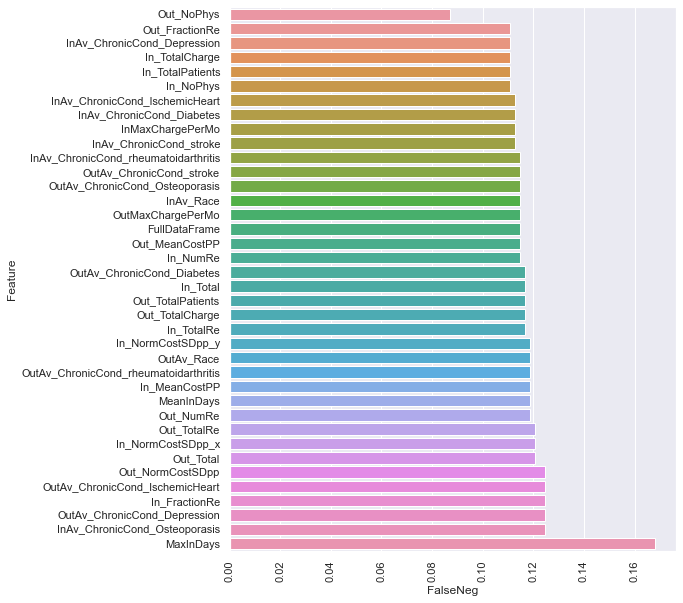

In [58]:
# Plot out data by feature versus the effect on the FalseNegative rate (or False Positive rate) or R-squared 
sns.set(rc={"figure.figsize":(8, 10)})
ax = sns.barplot(data=badFeatures.sort_values(by="FalseNeg"),y="Feature",x="FalseNeg")
ax.tick_params(axis='x', rotation=90)

In [59]:
# Test effects of newly deleted features
# This step can be performed iteratively to study the effects of deleting multiple columns
dropColumnsList = ["Out_NoPhys", "OutAv_ChronicCond_Osteoporasis", "OutAv_ChronicCond_IschemicHeart", 'In_NumRe']
improvedSMOTEX = x_res.drop(dropColumnsList,axis=1)
improvedWhole = Xdata.drop(dropColumnsList,axis=1)
badFeatures2 = identifyBadFeatures(improvedSMOTEX, y_res, modelScoreAll, improvedWhole, Ydata)

Analyzing:  Out_NumRe
Analyzing:  Out_TotalRe
Analyzing:  Out_Total
Analyzing:  Out_FractionRe
Analyzing:  In_TotalRe
Analyzing:  In_Total
Analyzing:  In_FractionRe
Analyzing:  In_TotalCharge
Analyzing:  In_TotalPatients
Analyzing:  In_MeanCostPP
Analyzing:  In_NormCostSDpp_x
Analyzing:  Out_TotalCharge
Analyzing:  Out_TotalPatients
Analyzing:  Out_MeanCostPP
Analyzing:  Out_NormCostSDpp
Analyzing:  In_NormCostSDpp_y
Analyzing:  OutMaxChargePerMo
Analyzing:  InMaxChargePerMo
Analyzing:  In_NoPhys
Analyzing:  MaxInDays
Analyzing:  MeanInDays
Analyzing:  OutAv_ChronicCond_Depression
Analyzing:  OutAv_ChronicCond_Diabetes
Analyzing:  OutAv_ChronicCond_rheumatoidarthritis
Analyzing:  OutAv_ChronicCond_stroke
Analyzing:  OutAv_Race
Analyzing:  InAv_ChronicCond_Depression
Analyzing:  InAv_ChronicCond_Diabetes
Analyzing:  InAv_ChronicCond_IschemicHeart
Analyzing:  InAv_ChronicCond_Osteoporasis
Analyzing:  InAv_ChronicCond_rheumatoidarthritis
Analyzing:  InAv_ChronicCond_stroke
Analyzing:  InA

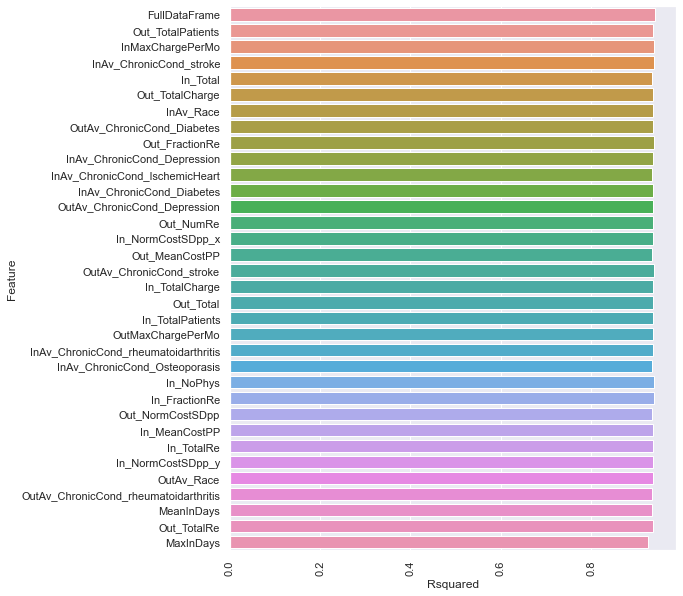

In [62]:
# Plot out data by dropped feature versus the effect on the R-squared value for the full data set
sns.set(rc={"figure.figsize":(8, 10)})
ax = sns.barplot(data=badFeatures2.sort_values(by="FalsePos"),y="Feature",x="Rsquared")
ax.tick_params(axis='x', rotation=90)

In [76]:
#####################################################################################################
# Train final boosting model based on best features
#####################################################################################################
smoteModel_red = gbm.fit(improvedSMOTEX, y_res)

In [78]:
# Confirm best R-squared value
print('R-squared for full data set: %.3f' %(smoteModel_red.score(improvedWhole, Ydata)))

R-squared for full data set: 0.940


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

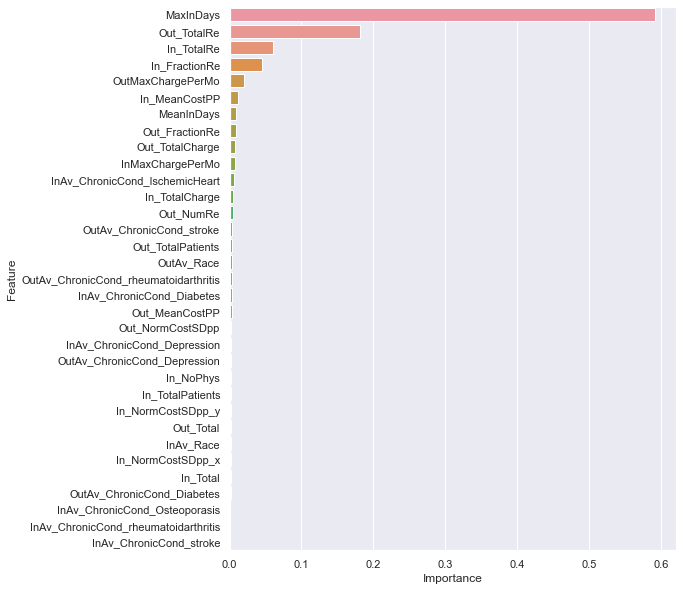

In [79]:
# Feature Importance for the final model
FI = pd.DataFrame({'Feature':improvedWhole.columns, 'Importance':list(smoteModel_red.feature_importances_)})
FI = FI.sort_values(by="Importance", ascending=False)
# Plot out feature importance
sns.set(rc={"figure.figsize":(8, 10)})
sns.barplot(data=FI,y="Feature",x="Importance")

In [81]:
# Confusion matrix for the final model
pred = pd.DataFrame({"Prediction":smoteModel_red.predict(improvedWhole)})
ydata = pd.DataFrame({"Actual":Ydata})
ydata.index = pred.index
pred["Actual"] = ydata["Actual"]
cm = pd.DataFrame(confusion_matrix(pred["Actual"], pred["Prediction"]))
cm.index = ["No Fraud", "Fraud"]
cm.columns = ["No Fraud", "Fraud"]
cm

,No Fraud,Fraud
No Fraud,4621,283
Fraud,41,465


Text(21.499999999999996, 0.5, 'Actual')

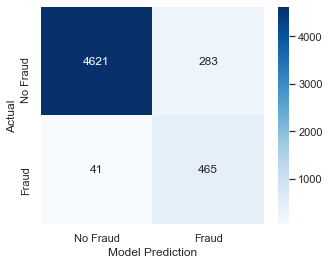

In [82]:
# Plot the confusion matrix
#fig = plt.figure()
sns.set(rc={"figure.figsize":(5,4)})
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
ax.set_xlabel ('Model Prediction', fontsize = 12)
ax.set_ylabel ('Actual', fontsize = 12)